此外，我们将添加功能以记录每个训练轮次的训练损失和验证损失，并在训练完成后绘制损失曲线，以便您可以观察模型的收敛情况并确定合适的训练轮次数。

以下是详细的步骤和相应的代码拆分：

1. 导入依赖和设置设备
首先，导入所有必要的库，并设置训练所使用的设备（CPU或GPU）。

In [2]:
# 导入依赖库
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

# 设置随机种子以确保可重复性
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")


使用设备: cuda


# 2. 加载CLIP模型并生成文本嵌入
加载CLIP模型，并预先计算文本提示词的嵌入，以避免在训练过程中重复计算。

In [14]:
# 加载CLIP模型
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# 文本提示词
TEXT_PROMPTS = [
    "A portrait of a young woman",
    "A realistic face with a smile",
    "A person with distinct facial features"
]

# 生成CLIP文本嵌入（提前计算以避免重复计算）
def generate_text_embeddings(text_prompts):
    text_tokens = clip.tokenize(text_prompts).to(device)
    with torch.no_grad():
        text_embeddings = clip_model.encode_text(text_tokens)
    return text_embeddings.cpu()  # 移动到CPU

# 预先计算文本嵌入
CLIP_TEXT_EMBEDDINGS = generate_text_embeddings(TEXT_PROMPTS)
print("已生成文本嵌入")


已生成文本嵌入


# 3. 定义CelebA数据集类
定义用于加载和预处理CelebA数据集的自定义Dataset类。

In [15]:
# CelebA数据集类
class CelebADataset(Dataset):
    def __init__(self, img_dir, attr_path, bbox_path, partition_path, 
                 transform=None, partition=0):
        """
        初始化数据集
        :param img_dir: 图像文件夹路径
        :param attr_path: 属性文件路径
        :param bbox_path: 边界框文件路径
        :param partition_path: 分区文件路径
        :param transform: 图像预处理
        :param partition: 使用的数据分区 (0: train, 1: val, 2: test)
        """
        self.img_dir = img_dir
        self.transform = transform

        # 读取属性文件
        attr_df = pd.read_csv(attr_path, sep=',', header=0)
        partition_df = pd.read_csv(partition_path, sep=',', header=0)
        
        # 合并属性文件和分区文件
        attr_df = attr_df.merge(partition_df, on='image_id')
        
        # 根据指定的分区进行筛选
        self.attr_df = attr_df[attr_df['partition'] == partition]
        
        # 读取边界框文件
        bbox_df = pd.read_csv(bbox_path, sep=',', header=0)
        
        # 合并边界框信息
        self.attr_df = self.attr_df.merge(bbox_df, on='image_id')

    def __len__(self):
        return len(self.attr_df)

    def __getitem__(self, idx):
        # 获取图像文件名
        img_name = self.attr_df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        
        # 打开图像并转换为RGB
        image = Image.open(img_path).convert('RGB')
        
        # 获取属性标签 
        attrs = self.attr_df.iloc[idx, 1:41].values
        attrs = (attrs + 1) // 2  # 将-1转为0，1保持1
        attrs = attrs.astype(np.float32)
        
        # 应用图像预处理
        if self.transform:
            image = self.transform(image)
        
        # 随机选择一个CLIP文本嵌入
        random_idx = random.randint(0, len(CLIP_TEXT_EMBEDDINGS) - 1)
        clip_embedding = CLIP_TEXT_EMBEDDINGS[random_idx]
        
        return image, attrs, clip_embedding


# 4. 定义ClipCVAE模型
定义条件变分自编码器（ClipCVAE）模型，该模型结合了图像、属性标签和CLIP嵌入。

In [16]:
class ClipCVAE(nn.Module):
    def __init__(self, img_channels=3, img_size=64, latent_dim=128, 
                 cond_dim=40, clip_dim=512):
        super(ClipCVAE, self).__init__()
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.clip_dim = clip_dim

        # 编码器部分
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels + cond_dim + clip_dim, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(512*4*4, latent_dim)
        self.fc_logvar = nn.Linear(512*4*4, latent_dim)

        # 解码器部分
        self.decoder_input = nn.Linear(latent_dim + cond_dim + clip_dim, 512*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, img_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x, c, clip_embedding):
        # 将条件标签、图像和CLIP嵌入拼接
        c = c.view(c.size(0), self.cond_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        clip_embedding = clip_embedding.view(clip_embedding.size(0), self.clip_dim, 1, 1).repeat(1, 1, self.img_size, self.img_size)
        x = torch.cat([x, c, clip_embedding], dim=1)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c, clip_embedding):
        # 将潜在变量、条件标签和CLIP嵌入拼接
        z = torch.cat([z, c, clip_embedding], dim=1)
        x = self.decoder_input(z)
        x = x.view(-1, 512, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x, c, clip_embedding):
        mu, logvar = self.encode(x, c, clip_embedding)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c, clip_embedding)
        return recon_x, mu, logvar


# 5. 数据预处理和创建数据加载器
定义图像预处理步骤，并创建训练集和验证集的数据加载器。

In [17]:
# 图像预处理
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 修正归一化
])

# 数据集路径设置（请根据实际路径修改）
img_dir = '/root/autodl-tmp/celeba_datasets/img_align_celeba/img_align_celeba'
attr_path = '/root/autodl-tmp/celeba_datasets/list_attr_celeba.txt'
bbox_path = '/root/autodl-tmp/celeba_datasets/list_bbox_celeba.txt'
partition_path = '/root/autodl-tmp/celeba_datasets/list_eval_partition.txt'

# 创建训练集和验证集
train_dataset = CelebADataset(img_dir, attr_path, bbox_path, partition_path, 
                              transform=transform, partition=0)
val_dataset = CelebADataset(img_dir, attr_path, bbox_path, partition_path, 
                            transform=transform, partition=1)

# 数据加载器
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")


训练集大小: 162770
验证集大小: 19867


# 6. 初始化模型、损失函数和优化器
初始化ClipCVAE模型、定义损失函数和优化器。

In [25]:
# 初始化模型参数
latent_dim = 128
cond_dim = 40
clip_dim = 512

# 定义一个函数来创建模型
def create_model():
    return ClipCVAE(img_channels=3, img_size=64, latent_dim=latent_dim, 
                   cond_dim=cond_dim, clip_dim=clip_dim)

# 初始化模型
model = create_model().to(device)

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 定义损失函数
criterion = nn.MSELoss(reduction='sum')

# 定义综合损失函数
def loss_function(recon_x, x, mu, logvar):
    recon_loss = criterion(recon_x, x)
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + KL

print("模型、优化器和损失函数已初始化")


模型、优化器和损失函数已初始化


# 7. 定义训练和验证函数
定义训练过程，同时记录每个epoch的训练损失和验证损失。

In [19]:
# 训练模型
def train_model(model, train_loader, val_loader, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        for batch_idx, (data, attrs, clip_emb) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")):
            data = data.to(device, non_blocking=True)
            attrs = attrs.to(device, non_blocking=True)
            clip_emb = clip_emb.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, attrs, clip_emb)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch}, 平均训练损失: {avg_train_loss:.4f}")
        
        # 验证集评估
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, attrs, clip_emb in val_loader:
                data = data.to(device, non_blocking=True)
                attrs = attrs.to(device, non_blocking=True)
                clip_emb = clip_emb.to(device, non_blocking=True)
                recon_batch, mu, logvar = model(data, attrs, clip_emb)
                loss = loss_function(recon_batch, data, mu, logvar)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        print(f"验证集平均损失: {avg_val_loss:.4f}")
    
    return model, train_losses, val_losses


In [26]:
# 训练模型
def train_model(model, train_loader, val_loader, optimizer, loss_function, num_epochs=50, device='cpu'):
    train_losses = []
    val_losses = []
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = 0
        for batch_idx, (data, attrs, clip_emb) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}")):
            data = data.to(device, non_blocking=True)
            attrs = attrs.to(device, non_blocking=True)
            clip_emb = clip_emb.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, attrs, clip_emb)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        
        avg_train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch}, 平均训练损失: {avg_train_loss:.4f}")
        
        # 验证集评估
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, attrs, clip_emb in val_loader:
                data = data.to(device, non_blocking=True)
                attrs = attrs.to(device, non_blocking=True)
                clip_emb = clip_emb.to(device, non_blocking=True)
                recon_batch, mu, logvar = model(data, attrs, clip_emb)
                loss = loss_function(recon_batch, data, mu, logvar)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        print(f"验证集平均损失: {avg_val_loss:.4f}")
    
    return train_losses, val_losses


# 模块8：多次训练并记录损失
实现多次训练（在相同的训练轮次下），记录每次训练的训练损失和验证损失，最后计算损失的平均值。

In [22]:
# 定义一个函数来进行多次训练并记录损失
def multiple_train_runs(num_runs, num_epochs, model_class, create_model_fn, train_loader, val_loader, 
                       optimizer_class, device='cpu'):
    all_train_losses = []
    all_val_losses = []
    
    for run in range(1, num_runs + 1):
        print(f"\n开始第 {run} 次训练")
        
        # 初始化模型
        model = create_model_fn().to(device)
        
        # 定义优化器
        optimizer = optimizer_class(model.parameters(), lr=1e-3)
        
        # 定义综合损失函数
        def current_loss_function(recon_x, x, mu, logvar):
            recon_loss = criterion(recon_x, x)  # 使用全局的criterion
            KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            return recon_loss + KL
        
        # 训练模型
        train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, 
                                             current_loss_function, num_epochs=num_epochs, device=device)
        
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
    
    # 计算平均损失
    avg_train_losses = np.mean(all_train_losses, axis=0)
    avg_val_losses = np.mean(all_val_losses, axis=0)
    
    return avg_train_losses, avg_val_losses

# 设置多次训练参数
num_runs = 5        # 例如进行5次训练
num_epochs = 20     # 训练轮次


# 8. 训练模型并记录损失
运行训练函数，并记录每个epoch的训练损失和验证损失。

In [9]:
# 设置训练参数
num_epochs = 20  # 您可以根据需要调整轮次数

# 训练模型
trained_model, train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, num_epochs=num_epochs)


Epoch 1/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.01it/s]

Epoch 1, 平均训练损失: 1089.5572


验证集平均损失: 629.5886


Epoch 2/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.66it/s]

Epoch 2, 平均训练损失: 573.1382


验证集平均损失: 545.3087


Epoch 3/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.10it/s]

Epoch 3, 平均训练损失: 521.1241


验证集平均损失: 498.7524


Epoch 4/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.67it/s]

Epoch 4, 平均训练损失: 499.0015


验证集平均损失: 495.2658


Epoch 5/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.66it/s]


Epoch 5, 平均训练损失: 481.3500
验证集平均损失: 480.2072


Epoch 6/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.46it/s]

Epoch 6, 平均训练损失: 468.2933


验证集平均损失: 466.3157


Epoch 7/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.49it/s]

Epoch 7, 平均训练损失: 460.4581


验证集平均损失: 455.1538


Epoch 8/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.60it/s]

Epoch 8, 平均训练损失: 453.5223


验证集平均损失: 452.5001


Epoch 9/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.19it/s]

Epoch 9, 平均训练损失: 449.0851


验证集平均损失: 442.6504


Epoch 10/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.39it/s]

Epoch 10, 平均训练损失: 445.7276


验证集平均损失: 439.2866


Epoch 11/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.31it/s]

Epoch 11, 平均训练损失: 442.9745


验证集平均损失: 442.4857


Epoch 12/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.07it/s]

Epoch 12, 平均训练损失: 439.0690


验证集平均损失: 439.8677


Epoch 13/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.85it/s]

Epoch 13, 平均训练损失: 436.8409


验证集平均损失: 434.2205


Epoch 14/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.79it/s]

Epoch 14, 平均训练损失: 434.7482


验证集平均损失: 432.3250


Epoch 15/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.55it/s]

Epoch 15, 平均训练损失: 432.4617


验证集平均损失: 433.8562


Epoch 16/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.42it/s]

Epoch 16, 平均训练损失: 430.7883


验证集平均损失: 434.2021


Epoch 17/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.06it/s]

Epoch 17, 平均训练损失: 428.9728


验证集平均损失: 435.6557


Epoch 18/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.12it/s]

Epoch 18, 平均训练损失: 427.9210


验证集平均损失: 431.5653


Epoch 19/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.96it/s]

Epoch 19, 平均训练损失: 426.1839


验证集平均损失: 435.5927


Epoch 20/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.59it/s]

Epoch 20, 平均训练损失: 425.2286


验证集平均损失: 427.8935


In [27]:
# 执行多次训练
avg_train_losses, avg_val_losses = multiple_train_runs(
    num_runs=num_runs,
    num_epochs=num_epochs,
    model_class=ClipCVAE,
    create_model_fn=create_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer_class=optim.Adam,
    device=device
)

print("多次训练完成，已记录平均损失")



开始第 1 次训练


Epoch 1/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.25it/s]

Epoch 1, 平均训练损失: 1109.1761


验证集平均损失: 654.6755


Epoch 2/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.28it/s]

Epoch 2, 平均训练损失: 571.5988


验证集平均损失: 527.4665


Epoch 3/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.10it/s]

Epoch 3, 平均训练损失: 520.4256


验证集平均损失: 519.5875


Epoch 4/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.54it/s]

Epoch 4, 平均训练损失: 498.3304


验证集平均损失: 492.7929


Epoch 5/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.80it/s]

Epoch 5, 平均训练损失: 482.5587


验证集平均损失: 472.7420


Epoch 6/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.37it/s]

Epoch 6, 平均训练损失: 469.8830


验证集平均损失: 466.8102


Epoch 7/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.13it/s]

Epoch 7, 平均训练损失: 460.9287


验证集平均损失: 462.5671


Epoch 8/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.29it/s]

Epoch 8, 平均训练损失: 454.4333


验证集平均损失: 453.5757


Epoch 9/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.94it/s]

Epoch 9, 平均训练损失: 449.4697


验证集平均损失: 451.3905


Epoch 10/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.72it/s]

Epoch 10, 平均训练损失: 446.5880


验证集平均损失: 442.4197


Epoch 11/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.25it/s]

Epoch 11, 平均训练损失: 442.0679


验证集平均损失: 442.1471


Epoch 12/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.67it/s]

Epoch 12, 平均训练损失: 439.3218


验证集平均损失: 438.6197


Epoch 13/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.11it/s]

Epoch 13, 平均训练损失: 437.3362


验证集平均损失: 435.2298


Epoch 14/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.88it/s]

Epoch 14, 平均训练损失: 434.4797


验证集平均损失: 438.1674


Epoch 15/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.88it/s]

Epoch 15, 平均训练损失: 432.9267


验证集平均损失: 432.4211


Epoch 16/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.02it/s]

Epoch 16, 平均训练损失: 430.6292


验证集平均损失: 437.9184


Epoch 17/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.78it/s]

Epoch 17, 平均训练损失: 428.9866


验证集平均损失: 432.3333


Epoch 18/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.00it/s]

Epoch 18, 平均训练损失: 427.4399


验证集平均损失: 426.5107


Epoch 19/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.40it/s]

Epoch 19, 平均训练损失: 426.1273


验证集平均损失: 430.9456


Epoch 20/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.06it/s]

Epoch 20, 平均训练损失: 424.6841


验证集平均损失: 429.3817

开始第 2 次训练


Epoch 1/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.28it/s]

Epoch 1, 平均训练损失: 1172.6225


验证集平均损失: 674.2778


Epoch 2/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.38it/s]

Epoch 2, 平均训练损失: 591.6476


验证集平均损失: 536.6882


Epoch 3/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.24it/s]

Epoch 3, 平均训练损失: 528.0889


验证集平均损失: 502.7348


Epoch 4/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.56it/s]

Epoch 4, 平均训练损失: 503.7113


验证集平均损失: 492.1616


Epoch 5/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.21it/s]

Epoch 5, 平均训练损失: 487.1208


验证集平均损失: 476.6405


Epoch 6/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.86it/s]

Epoch 6, 平均训练损失: 472.5621


验证集平均损失: 463.4045


Epoch 7/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.73it/s]

Epoch 7, 平均训练损失: 463.2770


验证集平均损失: 462.6568


Epoch 8/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.32it/s]

Epoch 8, 平均训练损失: 456.4167


验证集平均损失: 451.6324


Epoch 9/20: 100%|██████████| 1272/1272 [01:01<00:00, 20.54it/s]

Epoch 9, 平均训练损失: 450.9549


验证集平均损失: 444.3760


Epoch 10/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.12it/s]

Epoch 10, 平均训练损失: 446.3872


验证集平均损失: 446.7010


Epoch 11/20: 100%|██████████| 1272/1272 [01:00<00:00, 20.88it/s]

Epoch 11, 平均训练损失: 443.0122


验证集平均损失: 445.8906


Epoch 12/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.90it/s]

Epoch 12, 平均训练损失: 440.3277


验证集平均损失: 439.1687


Epoch 13/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.27it/s]

Epoch 13, 平均训练损失: 437.1440


验证集平均损失: 437.0066


Epoch 14/20: 100%|██████████| 1272/1272 [01:08<00:00, 18.69it/s]

Epoch 14, 平均训练损失: 435.0400


验证集平均损失: 433.2509


Epoch 15/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.30it/s]

Epoch 15, 平均训练损失: 433.0643


验证集平均损失: 441.4162


Epoch 16/20: 100%|██████████| 1272/1272 [01:08<00:00, 18.55it/s]

Epoch 16, 平均训练损失: 431.5835


验证集平均损失: 433.8091


Epoch 17/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.06it/s]

Epoch 17, 平均训练损失: 429.7592


验证集平均损失: 429.8730


Epoch 18/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.01it/s]

Epoch 18, 平均训练损失: 428.1817


验证集平均损失: 427.2033


Epoch 19/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.10it/s]

Epoch 19, 平均训练损失: 426.2785


验证集平均损失: 429.1929


Epoch 20/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.83it/s]

Epoch 20, 平均训练损失: 424.6964


验证集平均损失: 428.6853

开始第 3 次训练


Epoch 1/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.23it/s]

Epoch 1, 平均训练损失: 1166.1513


验证集平均损失: 691.6944


Epoch 2/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.17it/s]

Epoch 2, 平均训练损失: 597.7332


验证集平均损失: 537.0398


Epoch 3/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.22it/s]

Epoch 3, 平均训练损失: 532.2814


验证集平均损失: 518.0662


Epoch 4/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.97it/s]

Epoch 4, 平均训练损失: 505.6976


验证集平均损失: 489.3164


Epoch 5/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.80it/s]

Epoch 5, 平均训练损失: 491.6756


验证集平均损失: 489.7206


Epoch 6/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.07it/s]

Epoch 6, 平均训练损失: 477.2990


验证集平均损失: 474.9004


Epoch 7/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.13it/s]

Epoch 7, 平均训练损失: 465.4861


验证集平均损失: 462.5375


Epoch 8/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.32it/s]

Epoch 8, 平均训练损失: 457.8004


验证集平均损失: 457.6983


Epoch 9/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.50it/s]

Epoch 9, 平均训练损失: 451.4528


验证集平均损失: 449.3554


Epoch 10/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.18it/s]

Epoch 10, 平均训练损失: 447.6094


验证集平均损失: 443.3092


Epoch 11/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.83it/s]

Epoch 11, 平均训练损失: 444.4128


验证集平均损失: 440.5528


Epoch 12/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.88it/s]

Epoch 12, 平均训练损失: 441.1297


验证集平均损失: 448.5197


Epoch 13/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.92it/s]

Epoch 13, 平均训练损失: 438.4022


验证集平均损失: 436.6609


Epoch 14/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.80it/s]

Epoch 14, 平均训练损失: 436.1983


验证集平均损失: 438.0727


Epoch 15/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.77it/s]

Epoch 15, 平均训练损失: 433.8610


验证集平均损失: 433.7752


Epoch 16/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.35it/s]

Epoch 16, 平均训练损失: 432.7544


验证集平均损失: 432.9836


Epoch 17/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.92it/s]

Epoch 17, 平均训练损失: 430.6560


验证集平均损失: 430.8112


Epoch 18/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.40it/s]

Epoch 18, 平均训练损失: 429.2352


验证集平均损失: 435.2817


Epoch 19/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.39it/s]

Epoch 19, 平均训练损失: 427.3026


验证集平均损失: 429.7150


Epoch 20/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.06it/s]

Epoch 20, 平均训练损失: 426.3564


验证集平均损失: 430.1463

开始第 4 次训练


Epoch 1/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.50it/s]

Epoch 1, 平均训练损失: 1186.1887


验证集平均损失: 677.0821


Epoch 2/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.33it/s]

Epoch 2, 平均训练损失: 580.4189


验证集平均损失: 545.6544


Epoch 3/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.05it/s]

Epoch 3, 平均训练损失: 523.1273


验证集平均损失: 507.2058


Epoch 4/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.37it/s]

Epoch 4, 平均训练损失: 500.5088


验证集平均损失: 482.5028


Epoch 5/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.56it/s]

Epoch 5, 平均训练损失: 484.2335


验证集平均损失: 474.3599


Epoch 6/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.91it/s]

Epoch 6, 平均训练损失: 470.0154


验证集平均损失: 459.3513


Epoch 7/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.63it/s]

Epoch 7, 平均训练损失: 461.6425


验证集平均损失: 459.3824


Epoch 8/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.99it/s]

Epoch 8, 平均训练损失: 454.7843


验证集平均损失: 461.4598


Epoch 9/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.74it/s]

Epoch 9, 平均训练损失: 450.8864


验证集平均损失: 445.0357


Epoch 10/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.33it/s]

Epoch 10, 平均训练损失: 447.3501


验证集平均损失: 445.3730


Epoch 11/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.00it/s]

Epoch 11, 平均训练损失: 443.0523


验证集平均损失: 451.0231


Epoch 12/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.64it/s]

Epoch 12, 平均训练损失: 440.3788


验证集平均损失: 438.8611


Epoch 13/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.70it/s]

Epoch 13, 平均训练损失: 437.9075


验证集平均损失: 434.6616


Epoch 14/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.65it/s]

Epoch 14, 平均训练损失: 435.6549


验证集平均损失: 437.7739


Epoch 15/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.22it/s]

Epoch 15, 平均训练损失: 433.2368


验证集平均损失: 434.2720


Epoch 16/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.71it/s]

Epoch 16, 平均训练损失: 431.7277


验证集平均损失: 434.9260


Epoch 17/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.36it/s]

Epoch 17, 平均训练损失: 429.4917


验证集平均损失: 431.8654


Epoch 18/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.01it/s]

Epoch 18, 平均训练损失: 428.3583


验证集平均损失: 429.0157


Epoch 19/20: 100%|██████████| 1272/1272 [01:02<00:00, 20.41it/s]

Epoch 19, 平均训练损失: 427.0678


验证集平均损失: 426.8366


Epoch 20/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.25it/s]

Epoch 20, 平均训练损失: 425.7630


验证集平均损失: 426.7064

开始第 5 次训练


Epoch 1/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.14it/s]

Epoch 1, 平均训练损失: 1291.9307


验证集平均损失: 789.9093


Epoch 2/20: 100%|██████████| 1272/1272 [01:08<00:00, 18.70it/s]


Epoch 2, 平均训练损失: 668.6345
验证集平均损失: 583.6699


Epoch 3/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.70it/s]

Epoch 3, 平均训练损失: 558.3537


验证集平均损失: 538.3079


Epoch 4/20: 100%|██████████| 1272/1272 [01:08<00:00, 18.66it/s]

Epoch 4, 平均训练损失: 519.2942


验证集平均损失: 507.2484


Epoch 5/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.07it/s]

Epoch 5, 平均训练损失: 501.4830


验证集平均损失: 492.9773


Epoch 6/20: 100%|██████████| 1272/1272 [01:06<00:00, 19.09it/s]

Epoch 6, 平均训练损失: 488.0714


验证集平均损失: 479.4084


Epoch 7/20: 100%|██████████| 1272/1272 [01:03<00:00, 19.90it/s]

Epoch 7, 平均训练损失: 473.8585


验证集平均损失: 471.1952


Epoch 8/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.85it/s]

Epoch 8, 平均训练损失: 465.4525


验证集平均损失: 464.6557


Epoch 9/20: 100%|██████████| 1272/1272 [01:03<00:00, 20.13it/s]

Epoch 9, 平均训练损失: 459.0046


验证集平均损失: 461.3447


Epoch 10/20: 100%|██████████| 1272/1272 [01:06<00:00, 18.99it/s]

Epoch 10, 平均训练损失: 452.8786


验证集平均损失: 451.7808


Epoch 11/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.45it/s]

Epoch 11, 平均训练损失: 449.2166


验证集平均损失: 445.1015


Epoch 12/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.94it/s]

Epoch 12, 平均训练损失: 445.2784


验证集平均损失: 442.3733


Epoch 13/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.39it/s]

Epoch 13, 平均训练损失: 442.4207


验证集平均损失: 443.0693


Epoch 14/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.89it/s]

Epoch 14, 平均训练损失: 439.7370


验证集平均损失: 439.5671


Epoch 15/20: 100%|██████████| 1272/1272 [01:04<00:00, 19.58it/s]

Epoch 15, 平均训练损失: 437.2022


验证集平均损失: 437.0258


Epoch 16/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.94it/s]

Epoch 16, 平均训练损失: 435.0951


验证集平均损失: 436.4081


Epoch 17/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.40it/s]

Epoch 17, 平均训练损失: 432.2258


验证集平均损失: 433.7449


Epoch 18/20: 100%|██████████| 1272/1272 [01:07<00:00, 18.90it/s]

Epoch 18, 平均训练损失: 431.2269


验证集平均损失: 430.7163


Epoch 19/20: 100%|██████████| 1272/1272 [01:05<00:00, 19.31it/s]

Epoch 19, 平均训练损失: 429.3801


验证集平均损失: 442.9112


Epoch 20/20: 100%|██████████| 1272/1272 [01:08<00:00, 18.66it/s]

Epoch 20, 平均训练损失: 427.9964


验证集平均损失: 430.3371
多次训练完成，已记录平均损失


# 9. 绘制训练和验证损失曲线
在训练完成后，绘制训练损失和验证损失的变化曲线，以便观察模型的收敛情况。


In [1]:
# 绘制损失曲线
def plot_average_loss(train_losses, val_losses, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(10,5))
    plt.plot(epochs, train_losses, 'b-', label='平均训练损失')
    plt.plot(epochs, val_losses, 'r-', label='平均验证损失')
    plt.title('多次训练的平均训练与验证损失曲线')
    plt.xlabel('轮次')
    plt.ylabel('损失')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_average_loss(avg_train_losses, avg_val_losses, num_epochs)


NameError: name 'avg_train_losses' is not defined

# 10. 保存模型
将训练好的模型参数保存到文件中，以便后续使用或加载。

In [ ]:
# 保存模型
torch.save(trained_model.state_dict(), 'clip_cvae_celeba.pth')
print("模型已保存为 'clip_cvae_celeba.pth'")



训练轮次: 10

开始第 1 次训练


Epoch 1/10:  12%|█▏        | 148/1272 [00:08<01:04, 17.56it/s]


KeyboardInterrupt: 

# 11. 定义图像生成函数
定义函数，根据条件标签和文本提示词生成新的图像。

In [11]:
# 图像生成函数
def generate_images(model, attrs, text_prompts, device, num_images=16):
    """
    根据条件标签和文本提示生成图像
    """
    model.eval()
    
    with torch.no_grad():
        z = torch.randn(num_images, model.latent_dim).to(device)
        attrs = attrs[:num_images].to(device)
        
        # 对于每个图像随机选择一个文本嵌入
        text_embeddings = torch.stack([
            CLIP_TEXT_EMBEDDINGS[random.randint(0, len(CLIP_TEXT_EMBEDDINGS) - 1)] 
            for _ in range(num_images)
        ]).to(device)
        
        generated = model.decode(z, attrs, text_embeddings)
        generated = generated.cpu()
        return generated


# 12. 生成并可视化示例图像
使用训练好的模型生成图像，并进行可视化。

/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23548 (\N{CJK UNIFIED IDEOGRAPH-5BFC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26465 (\N{CJK UNIFIED IDEOGRAPH-6761}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/pytorc_test1/lib/python3.12/site-packages/IPython/core/pyl

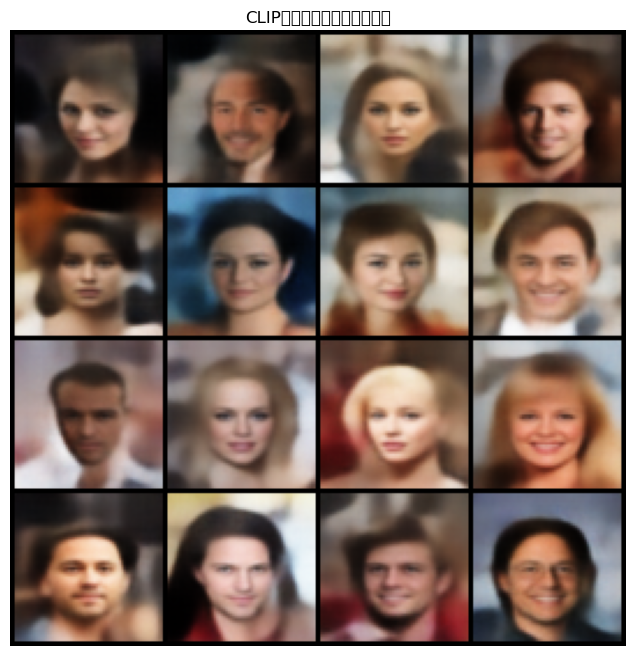

In [12]:
# 从验证集中获取样本属性
data_iter = iter(val_loader)
images, attrs, _ = next(data_iter)
sample_attrs = attrs[:16]

# 生成图像
generated_images = generate_images(trained_model, sample_attrs, TEXT_PROMPTS, device, num_images=16)

# 可视化生成的图像
def show_images(images, title="Generated Images"):
    images = images * 0.5 + 0.5  # 反归一化
    grid = torchvision.utils.make_grid(images, nrow=4)
    np_grid = grid.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

show_images(generated_images, title="CLIP引导的条件生成人脸图像")


# 13. 选择合适的训练轮次
通过观察绘制的损失曲线，您可以确定模型的收敛情况以及何时停止训练以避免过拟合。例如，如果训练损失和验证损失在某个轮次后趋于平稳，您可以选择在此轮次停止训练。

示例：

假设在20轮训练后，损失曲线如下：

(请将此链接替换为实际生成的损失曲线截图)

从图中可以看出，训练损失和验证损失在15轮左右趋于平稳，因此您可以选择将训练轮次设置为15。